In [ ]:
import time
import cvxpy as cp
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Dropout, LSTM ,Flatten
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import backend as K
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.datasets import mnist


import scipy.io as sio
from scipy.fftpack import fft,dct
from scipy.sparse import random

from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn import random_projection

In [ ]:
# Mounting drive for data

from google.colab import drive
drive.mount('/content/drive')
# root_path = 'gdrive/My Drive/fault_detection_data/'

Mounted at /content/drive


In [ ]:
# Setting up the data folder and working dir
import os 
# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "fault_detection_data/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/fault_detection_data/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [ ]:
# Types of faults and files collection
datadict = {
"b14": ["185.mat","186.mat","187.mat","188.mat"],
"b7" :  ["118.mat"  ,"119.mat",  "120.mat",  "121.mat"],
"ir21": ["209.mat"  ,"210.mat",  "211.mat",  "212.mat"],
"or14" : ["197.mat"  ,"198.mat",  "199.mat",  "200.mat"],
"or7" : ["130.mat"  ,"131.mat",  "132.mat",  "133.mat"],
"b21" : ["222.mat"  ,"223.mat",  "224.mat",  "225.mat"],
"ir14" : ["169.mat"  ,"170.mat"  ,"171.mat"  ,"172.mat"],
"ir7" : ["105.mat"  ,"106.mat",  "107.mat",  "108.mat"],
"normal" :["097.mat"  ,"098.mat",  "099.mat",  "100.mat"],
"or21" : ["234.mat"  ,"235.mat",  "236.mat",  "237.mat"]
}
%cd fault_detection_data
cwd = !pwd
# cwd
test = sio.loadmat(cwd[0]+"/"+"normal" +"/"+datadict["normal"][0])
test
# datadict["normal"][1][:-4]

[Errno 2] No such file or directory: 'fault_detection_data'
/content


{'X097RPM': array([[1796]], dtype=uint16),
 'X097_DE_time': array([[ 0.05319692],
        [ 0.08866154],
        [ 0.09971815],
        ...,
        [-0.03463015],
        [ 0.01668923],
        [ 0.04693846]]),
 'X097_FE_time': array([[0.14566727],
        [0.09779636],
        [0.05485636],
        ...,
        [0.14053091],
        [0.09553636],
        [0.09019455]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Jan 31 15:28:20 2000',
 '__version__': '1.0'}

/content/drive/My Drive/fault_detection_data
b14  b7    ir21  new_file_in_working_directory.txt  or14  or7
b21  ir14  ir7	 normal				    or21


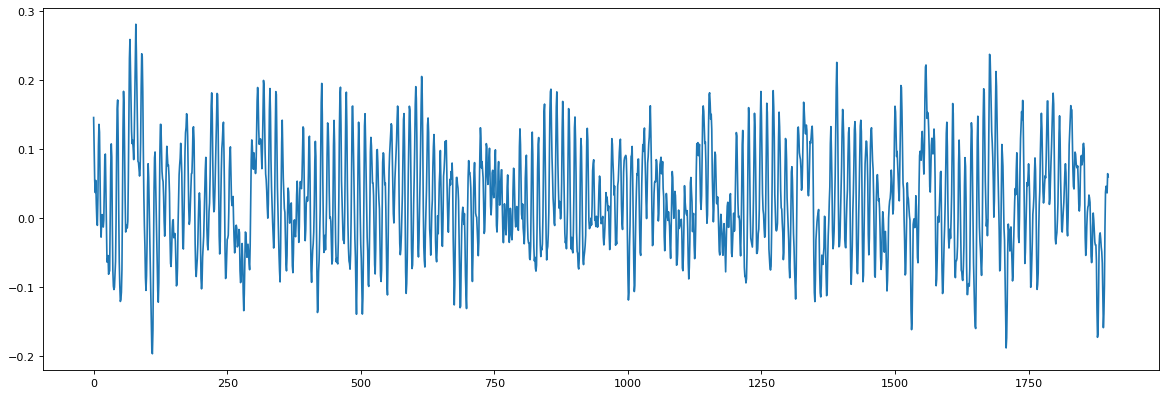

In [ ]:
!pwd
# %cd ..
# %cd normal
!ls
plt.figure(figsize=(18, 6), dpi=80)
plt.plot(test['X097_FE_time'][:1900])

In [ ]:
# Data Extraction and Compilation

frame_length =400
hop_size = 150
frame_matrix_x = np.asarray([np.empty([frame_length])])
frame_matrix_y = np.asarray([np.empty([1])])
types = ["b14","or14","ir14","normal"]
# types = ["b14","b7","b21","or14","or7","or21","ir14","ir7","ir21","normal"]

for idx,typ in enumerate(types):
  for i in range(4):
    test = sio.loadmat(cwd[0]+"/"+typ +"/"+datadict[typ][i])
    sig = np.squeeze(test["X"+datadict[typ][i][:-4]+"_FE_time"])
    number_of_frames = 1+np.int(np.floor((sig.shape[0]-frame_length)/hop_size))
    for i in range(number_of_frames):
      start = i*hop_size
      stop = np.minimum(start+frame_length,sig.shape[0])
      frame_matrix_x = np.vstack((frame_matrix_x,np.asarray(np.asarray(sig[start:stop]))))
      frame_matrix_y = np.vstack((frame_matrix_y,[int(idx)]))
      # print(frame_matrix)
    print(number_of_frames,frame_length,sig.shape,typ)
    # print(frame_matrix_x.shape)
    
print(type(sig))
print(type(test))
frame_matrix_x = frame_matrix_x[1:]
frame_matrix_y = frame_matrix_y[1:]
print(type(frame_matrix_x[0][0]),type(frame_matrix_x[0][1]))
print(frame_matrix_x[0].shape)
print(frame_matrix_x)

810 400 (121846,) b14
812 400 (122136,) b14
811 400 (121991,) b14
812 400 (122136,) b14
810 400 (121846,) or14
812 400 (122136,) or14
810 400 (121846,) or14
811 400 (121991,) or14
810 400 (121846,) ir14
810 400 (121846,) ir14
810 400 (121846,) ir14
809 400 (121701,) ir14
1624 400 (243938,) normal
3224 400 (483903,) normal
3232 400 (485063,) normal
3235 400 (485643,) normal
<class 'numpy.ndarray'>
<class 'dict'>
<class 'numpy.float64'> <class 'numpy.float64'>
(400,)
[[ 0.09697455  0.27058364  0.13642182 ... -0.15737818 -0.03081818
  -0.01725818]
 [ 0.04314545  0.01191636 -0.14196909 ...  0.08053818  0.02794182
   0.02383273]
 [ 0.10396     0.01088909  0.04622727 ...  0.19415455  0.10971273
   0.07314182]
 ...
 [ 0.17710182  0.15635091  0.07663455 ... -0.10765818 -0.10765818
  -0.06656727]
 [-0.03081818 -0.05115818 -0.04930909 ...  0.02547636  0.05978727
   0.06985455]
 [-0.03965273 -0.02855818  0.00184909 ...  0.09224909  0.03554364
  -0.03205091]]


In [ ]:
# fault_data = {'x': [frame_matrix_x], 'y': [frame_matrix_y]}
# df = pd.DataFrame({'x':frame_matrix_x, 'y':frame_matrix_y})
# # df = pd.DataFrame(frame_matrix_x, columns = ['x','y'])
# from sklearn.utils import shuffle
# df = shuffle(df)
# print(df.head())
# print(df.shape)


<class 'numpy.ndarray'> (21042, 400)
<class 'numpy.ndarray'> (21042, 4)
<class 'numpy.ndarray'> (21042, 360)
(360, 400)


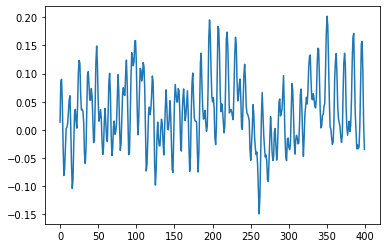

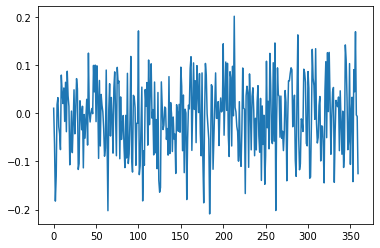

In [63]:
#frame_matrix dimension = (#samples, length of sample)
data_x_orig = frame_matrix_x #df['x'].to_numpy()
data_y_orig = frame_matrix_y# df['y'].to_numpy()

# Shuffling the data
p = np.random.permutation(len(data_x_orig))
data_x_orig = data_x_orig[p]
data_y_orig = data_y_orig[p]
data_y_orig = to_categorical(data_y_orig)

# print(data_x,data_y)
print(type(data_x_orig),data_x_orig.shape)
print(type(data_y_orig),data_y_orig.shape)

# Compressing data using Gaussian Random Matrix
compression_percentage =0.9
transformer = random_projection.GaussianRandomProjection(n_components=int(compression_percentage*frame_length))
data_x_compressed = transformer.fit_transform(data_x_orig)
print(type(data_x_compressed),data_x_compressed.shape)
plt.plot(data_x_orig[0])
plt.figure()
plt.plot(data_x_compressed[0])
A = np.asarray(transformer.components_)
print(A.shape)


In [64]:
data_x = data_x_compressed
data_y = data_y_orig
# Reshaping for CNN : 2D -> 3D
data_x = np.reshape(data_x, (data_x.shape[0],data_x.shape[1],1))
print(type(data_x),data_x.shape)

data_len = len(data_x)
trainx = data_x[:int(0.95*data_len)]
testx = data_x[int(0.95*data_len):]
trainy = data_y[:int(0.95*data_len)]
testy = data_y[int(0.95*data_len):]
print(trainx.shape)

<class 'numpy.ndarray'> (21042, 360, 1)
(19989, 360, 1)


In [65]:
# Model RNN
# verbose, epochs, batch_size = 1, 100, 64
# model = keras.models.Sequential()
# model.add(LSTM(250, activation='relu', input_shape=(trainx.shape[1],1))) 
# model.add(Dense(4, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# # model.summary()
# print(model.summary())
# tick1 = time.time()
# model.fit(trainx, trainy, validation_data=(testx, testy), epochs = epochs, batch_size =batch_size)
# tock1 = time.time()
# print(tock1-tick1)
# _, accuracy = model.evaluate(testx, testy, batch_size=batch_size, verbose=1)

In [87]:
# Model CNN
verbose, epochs, batch_size = 1, 1, 64

optimizer = keras.optimizers.Adam(learning_rate=0.2)

input = tf.keras.Input(shape=(data_x.shape[1],1), name='input')
# x = tf.keras.layers.Embedding(
    # output_dim=512, input_dim=10000, input_length=100)(input)
x = tf.keras.layers.Conv1D(filters=10, kernel_size=101, activation='relu')(input)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
output = tf.keras.layers.Dense(4, activation='softmax', name='output')(x)
model = tf.keras.Model(inputs=[input], outputs=[output])




# model = keras.models.Sequential()
# model.add(Conv1D(filters=10, kernel_size=101, activation='relu', input_shape=(data_x.shape[1],1)))
# model.add(MaxPooling1D(pool_size=2))
"""
# model.add(Conv1D(filters=5, kernel_size=51, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=5, kernel_size=26, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
"""
# model.add(Flatten())

# model.add(Dense(100,activation='relu'))
# model.add(Dense(4,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
es = EarlyStopping(monitor='loss', mode='min', verbose=1,patience = 15, min_delta = 0.001)
tick1 = time.time()
model.fit(trainx, trainy, epochs=epochs, batch_size=batch_size, verbose=1,validation_split=0.05,callbacks= [es])
tock1 = time.time()
print(model.summary())

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/tmp/model_plot.png', show_shapes=False, show_layer_names=True)
# from keras_visualizer import visualizer 
# visualizer(model, format='png', view=True)
print(tock1-tick1)
_, accuracy = model.evaluate(testx, testy, batch_size=batch_size, verbose=1)


297/297 [==============================] - 7s 22ms/step - loss: 0.5825 - accuracy: 0.7891 - val_loss: 0.2113 - val_accuracy: 0.9240
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 360, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 260, 10)           1020      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 130, 10)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1300)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               130100    
_________________________________________________________________
output (Dense)               (None, 4)                 404   

Text(0, 0.5, 'Validation Accuracy(%)')

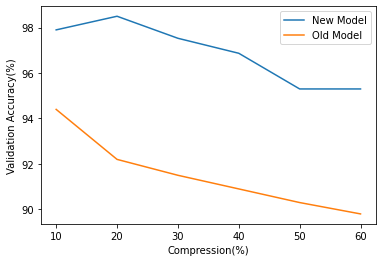

In [78]:
tm = [139,132,110,93,77,63]
accuracy =[97.9,98.5,97.53,96.87,95.3,95.3]
acc2 = [94.4,92.2,91.5,90.9,90.3,89.8]
cmpr = [10,20,30,40,50,60]
plt.plot(cmpr,accuracy,label = "New Model")
plt.plot(cmpr,acc2, label = "Old Model")
plt.legend()
plt.xlabel('Compression(%)')
plt.ylabel('Validation Accuracy(%)')

In [68]:
# Extra data model
len_data = len(trainx[0])
x_in = keras.Input(shape=(len_data))
lx = keras.layers.Dense(len_data/2, activation='relu')(x_in)# input_shape=[equations+ dimension*equations]),
x_out = keras.layers.Dense(len_data/4, activation='relu')(lx)
# modely = keras.Model(inputs=y_in, outputs=y_out, name="y_model")
dimension = A.shape[0]
equations = A.shape[1]

A_in = keras.Input(shape=(dimension*equations))
lA = keras.layers.Dense(dimension*equations/1000, activation='relu')(A_in)# input_shape=[equations+ dimension*equations]),
A_out = keras.layers.Dense(dimension*equations/4000, activation='relu')(lA)# input_shape=[equations+ dimension*equations]),
# modelA = keras.Model(inputs=A_in, outputs=A_out, name="A_model")
# print(modely.output.shape,modelA.output.shape)
combined = tf.keras.layers.concatenate([y_out, A_out])

lc1 = keras.layers.Dense(dimension*2, activation='relu')(combined)
lc2 = keras.layers.Dense(dimension, activation='relu')(lc1)
  # keras.layers.Dense(dimension, activation='sigmoid') # for sparse 1 0 output
c_out = keras.layers.Dense(dimension, activation='linear')(lc2) # for sparse 1 0 output
modelC = keras.Model(inputs=[x_in,A_in], outputs=c_out, name="c_model")
print(modelC.summary())

modelC.compile(loss='mse', optimizer='adam', metrics=['logcosh', 'mse'])
print(modelC.summary())
Aa= np.array(A)
A1 = np.reshape(Aa,(1,dimension*equations))
temp = np.ones(trainx.shape[0])
temp = np.reshape(temp,(trainx.shape[0],1))
temp = temp*A1
temp2 = np.ones(testx.shape[0])
temp2 = np.reshape(temp2,(testx.shape[0],1))
temp2 = temp2*A1
print("hello: " ,x_in.shape,temp.shape)
z = [trainx,temp]
print(len(z),len(z[0]),len(z[0][0]),len(z[1][0]))
history = modelC.fit([trainx,temp], trainy, epochs=epochs, batch_size=batch_size, verbose=1,validation_split=0.05)
_, accuracy = modelC.evaluate(testx, testy, batch_size=batch_size, verbose=1)


#evaluating on trained noise data
# eval_train_noise = model.evaluate(y[-eval_n:],x[-eval_n:],verbose=0)

#evaluating on high noise data
# diff = np.square(high_noise_data[0] - model.predict(high_noise_data[1]))
# mse_high_noise = (np.apply_along_axis(np.sum,1,diff))/(dimension)

# return np.average(mse_high_noise), eval_train_noise[0],model,history


NameError: ignored

In [ ]:
predicted = model.predict(testx)
tf.math.confusion_matrix(np.argmax(predicted,axis =1), np.argmax(testy,axis=1))
